In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337

set_seed(seed)

In [3]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [4]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [5]:
from core.models.exchange import ExchangeType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from exchange import ExchangeFactory

In [6]:
DEFAULT_EXCHANGE = ExchangeType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.ONE_HOUR
DEFAULT_LOOKBACK = Lookback.SIX_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

raw_df_filename = f'ocean_raw_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{today}.csv'
features_filename = f'ocean_features_{today}.npy'
emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_ft_{today}.csv'

In [7]:
exchange_factory = ExchangeFactory(EnvironmentSecretService())
exchange = exchange_factory.create(DEFAULT_EXCHANGE)

In [ ]:
symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    try:
        for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [ ]:
symbols_df.to_csv(raw_df_filename, index=False)

In [8]:
symbols_df = pd.read_csv(raw_df_filename)
float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [9]:
symbols_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume
0,10000000AIDOGEUSDT,2024-03-31 19:00:00,0.006044,0.006141,0.006008,0.006106,23899000.0
1,10000000AIDOGEUSDT,2024-03-31 20:00:00,0.006106,0.006145,0.006072,0.006089,14857800.0
2,10000000AIDOGEUSDT,2024-03-31 21:00:00,0.006089,0.006139,0.006016,0.006034,20731800.0
3,10000000AIDOGEUSDT,2024-03-31 22:00:00,0.006034,0.006072,0.006015,0.006053,11339100.0
4,10000000AIDOGEUSDT,2024-03-31 23:00:00,0.006053,0.006127,0.006047,0.006127,10254700.0


In [10]:
def volume_features(df, mfi_period=14):
    df = df.copy()

    df['Date'] = df['Timestamp'].dt.date

    df['ADV'] = df.groupby(['Symbol', 'Date'])['Volume'].transform('mean')

    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']

    df['Cum_Volume'] = df.groupby(['Symbol', 'Date'])['Volume'].cumsum()
    df['Cum_Price_Volume'] = df.groupby(['Symbol', 'Date'])['Cumulative Price * Volume'].cumsum()
    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume']

    df['Price Change'] = df.groupby(['Symbol', 'Date'])['Close'].diff()

    df['OBV_Sign'] = df['Price Change'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    df['OBV'] = (df['OBV_Sign'] * df['Volume']).groupby(df['Symbol']).cumsum()

    df['A/D'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']
    df['A/D'] = df.groupby(['Symbol', 'Date'])['A/D'].cumsum()

    df['Amihud_Illiquidity'] = df['Price Change'].abs() / df['Volume']
    df['Amihud_Illiquidity'] = df.groupby(['Symbol', 'Date'])['Amihud_Illiquidity'].transform('mean')

    df['Liquidity_Ratio'] = df['Volume'] / df['Typical Price']

    df['II'] = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']

    df['Raw Money Flow'] = df['Typical Price'] * df['Volume']
    df['Price Diff'] = df.groupby(['Symbol', 'Date'])['Typical Price'].diff()
    df['Positive Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] > 0, 0)
    df['Negative Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] < 0, 0)
    df['Positive Money Flow Sum'] = df.groupby('Symbol')['Positive Money Flow'].transform(lambda x: x.rolling(window=mfi_period).sum())
    df['Negative Money Flow Sum'] = df.groupby('Symbol')['Negative Money Flow'].transform(lambda x: x.rolling(window=mfi_period).sum())
    df['Money Flow Ratio'] = df['Positive Money Flow Sum'] / df['Negative Money Flow Sum']
    df['MFI'] = 100 - (100 / (1 + df['Money Flow Ratio']))

    df['Previous Close'] = df.groupby('Symbol')['Close'].shift(1)
    df['TR1'] = df['High'] - df['Low']
    df['TR2'] = (df['High'] - df['Previous Close']).abs()
    df['TR3'] = (df['Low'] - df['Previous Close']).abs()
    df['True Range'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

    df['Volume-Weighted_TR'] = df['True Range'] * df['Volume']

    df['LII'] = df['Volume'] / (df['Typical Price'] * df['True Range'])

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    df.drop(columns=[
        'Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume',
        'Price Change', 'OBV_Sign', 'Raw Money Flow', 'Price Diff', 'True Range', 'Money Flow Ratio',
        'Positive Money Flow', 'Negative Money Flow', 'Positive Money Flow Sum', 'Negative Money Flow Sum', 'Previous Close',  'TR1', 'TR2', 'TR3'
    ], inplace=True)

    return df

In [11]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

In [11]:
volume_df = pd.read_csv(volume_df_filename)

In [13]:
volume_df.shape[0]

1568128

In [14]:
volume_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume,ADV,VWAP,OBV,A/D,Amihud_Illiquidity,Liquidity_Ratio,II,MFI,Volume-Weighted_TR,LII
0,10000000AIDOGEUSDT,2024-03-31 19:00:00,0.006044,0.006141,0.006008,0.006106,23899000.0,16216480.0,0.006085,0.0,11320553.0,3.172232e-12,3.927526e+09,11320553.0,NaN,3178.5635,2.953031e+13
1,10000000AIDOGEUSDT,2024-03-31 20:00:00,0.006106,0.006145,0.006072,0.006089,14857800.0,16216480.0,0.006092,-14857800.0,3382796.0,3.172232e-12,2.434907e+09,-7937757.0,NaN,1084.6173,3.335495e+13
2,10000000AIDOGEUSDT,2024-03-31 21:00:00,0.006089,0.006139,0.006016,0.006034,20731800.0,16216480.0,0.006082,-35589600.0,-11281260.0,3.172232e-12,3.419396e+09,-14664056.0,NaN,2550.0066,2.780002e+13
3,10000000AIDOGEUSDT,2024-03-31 22:00:00,0.006034,0.006072,0.006015,0.006053,11339100.0,16216480.0,0.006076,-24250500.0,-7501498.5,3.172232e-12,1.875264e+09,3779761.5,NaN,646.3310,3.289926e+13
4,10000000AIDOGEUSDT,2024-03-31 23:00:00,0.006053,0.006127,0.006047,0.006127,10254700.0,16216480.0,0.006079,-13995800.0,2753201.5,3.172232e-12,1.681007e+09,10254700.0,NaN,820.3727,2.101267e+13


In [12]:
symbols = volume_df['Symbol'].unique()
n_symbols = len(symbols)

print("N Symbols: ", n_symbols)

N Symbols:  411


In [13]:
features = [
    'ADV', 'VWAP', 'OBV', 'Amihud_Illiquidity',
    'II', 'LII', 'A/D', 'MFI'
]
n_features = len(features)

print("N Features: ", n_features)

N Features:  8


In [17]:
segment_length = 512
overlap = 64

print("NaN values before imputation:\n", volume_df.isna().sum())
imputer = SimpleImputer(strategy='mean')
volume_df[features] = imputer.fit_transform(volume_df[features])
print("NaN values after imputation:\n", volume_df.isna().sum())

symbol_sequences = [volume_df[volume_df['Symbol'] == symbol][features].to_numpy() for symbol in symbols]
print("Symbol seq: ", len(symbol_sequences))

def segment_sequence(sequence, segment_length, overlap):
    segments = []
    step = segment_length - overlap

    for start in range(0, len(sequence), step):
        end = min(start + segment_length, len(sequence))
        segment = sequence[start:end]

        if len(segment) < segment_length:
            segment = np.pad(segment, ((0, segment_length - len(segment)), (0, 0)), 'constant')

        segments.append(segment)
    return segments

def segment_all_sequences(sequences, segment_length, overlap):
    segmented_sequences = []
    for seq in sequences:
        segmented_sequences.extend(segment_sequence(seq, segment_length, overlap))
    return segmented_sequences

segmented_sequences = segment_all_sequences(symbol_sequences, segment_length=segment_length, overlap=overlap)
segmented_sequences = np.array(segmented_sequences)

n_segments, segment_length, n_features = segmented_sequences.shape

scaler = StandardScaler()
segmented_sequences = segmented_sequences.reshape(-1, n_features)
normalized_segments = scaler.fit_transform(segmented_sequences)
normalized_segments = normalized_segments.reshape(n_segments, segment_length, n_features)

print("Shape of normalized features:", normalized_segments.shape)
print("Number of symbols:", n_symbols)

np.save(features_filename, normalized_segments)

NaN values before imputation:
 Symbol                   0
Timestamp                0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
ADV                      0
VWAP                     9
OBV                      0
A/D                    282
Amihud_Illiquidity       0
Liquidity_Ratio          0
II                     282
MFI                   5343
Volume-Weighted_TR       0
LII                    282
dtype: int64
NaN values after imputation:
 Symbol                0
Timestamp             0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
ADV                   0
VWAP                  0
OBV                   0
A/D                   0
Amihud_Illiquidity    0
Liquidity_Ratio       0
II                    0
MFI                   0
Volume-Weighted_TR    0
LII                   0
dtype: int64
Symbol seq:  411
Shape of normalized features:

In [9]:
from notebooks.pipelines import ocean_train

epochs = 1
latent_dim = 32
lr = 1e-6

ocean_train.run_training(
    features_filename=features_filename,
    emb_filename=emb_filename,
    epochs=epochs,
    latent_dim=latent_dim,
    lr=lr,
)

RANK: 0, WORLD_SIZE: 1
Loaded snapshot: snapshots/AutoEncoder_epoch_241_improved.pth
Epoch [1/1], Train Loss: 0.00930903
Saved improved snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_239_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_241_improved.pth
Training Complete
Loaded snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Embeddings shape: (3664, 32)


In [14]:
embeddings = np.load(emb_filename)

print("Embedding shape:", embeddings.shape)

num_symbols = len(symbols)
num_embeddings_per_symbol = embeddings.shape[0] // num_symbols

symbol_embeddings_dict = {symbol: [] for symbol in symbols}

for i, symbol in enumerate(symbols):
    start_index = i * num_embeddings_per_symbol
    end_index = start_index + num_embeddings_per_symbol

    symbol_embeddings_dict[symbol].extend(embeddings[start_index:end_index])

remaining_embeddings = embeddings.shape[0] % num_symbols

if remaining_embeddings > 0:
    symbol_embeddings_dict[symbols[-1]].extend(embeddings[-remaining_embeddings:])

df = pd.DataFrame({
    'symbol': symbol_embeddings_dict.keys(),
    'embeddings': symbol_embeddings_dict.values()
})

print("DF shape:", df.shape)
print("\n", df.head())

Embedding shape: (3664, 32)
DF shape: (411, 2)

                 symbol                                         embeddings
0   10000000AIDOGEUSDT  [[-0.22497347, 0.07945185, -0.13064767, -0.013...
1  1000000BABYDOGEUSDT  [[-0.31176528, -0.04433469, -0.20070145, -0.02...
2       1000000MOGUSDT  [[-0.2517286, 0.13134246, -0.22030273, 0.09421...
3    1000000PEIPEIUSDT  [[-0.27860305, 0.11634383, -0.18242435, 0.0481...
4         10000COQUSDT  [[-0.29162326, 0.01625024, -0.16535892, -0.043...


In [15]:
all_embeddings = np.vstack(df['embeddings'].values)

In [16]:
from sklearn.cluster import DBSCAN, KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
dbscan = DBSCAN(eps=0.5, min_samples=n_clusters)

In [17]:
kmeans.fit(all_embeddings)

k_cluster_labels = kmeans.labels_

print("KMeans cluster labels", len(k_cluster_labels))

KMeans cluster labels 3664


In [18]:
dbscan_labels = dbscan.fit_predict(all_embeddings)

print("DBSCAN cluster labels:", len(dbscan_labels))

DBSCAN cluster labels: 3664


In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=seed)
reduced_embeddings = pca.fit_transform(all_embeddings)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=seed)
reduced_embeddings = tsne.fit_transform(all_embeddings)

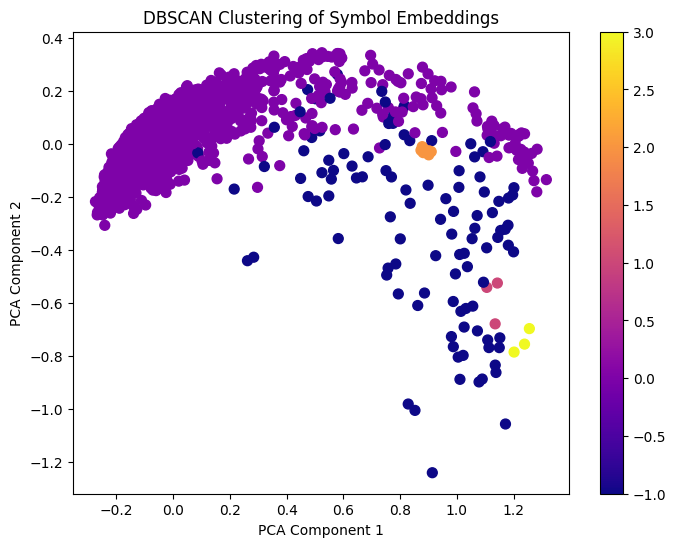

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='plasma', s=50)
plt.colorbar()
plt.title('DBSCAN Clustering of Symbol Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

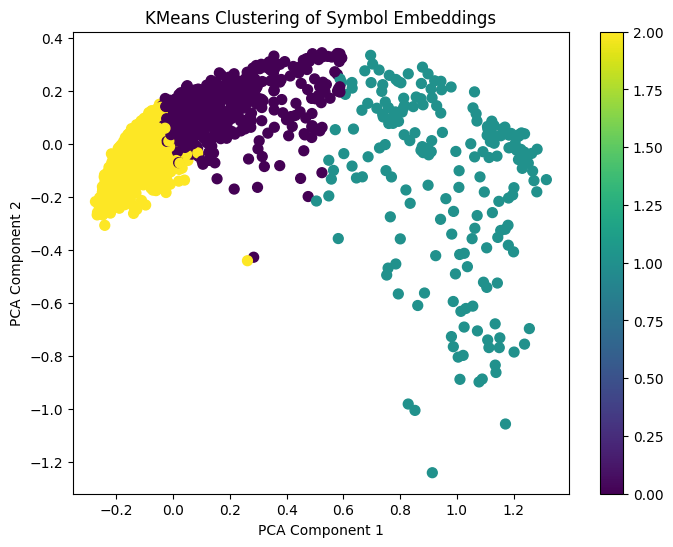

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=k_cluster_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('KMeans Clustering of Symbol Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()